In [1]:
import json
import yaml

import numpy as np
import pylab as plt

from pathlib import Path
import os

In [2]:
model_names = ['resnet6', 'resnet10', 'resnet18']
queries = ['random', 'coreset', 'margin', 'badge', 'typiclust']
use_SSL = ['False', 'True']
use_PRE = ['False', 'True']
Q = {'random':'Random', 'coreset':'CoreSets', 'badge':'BADGE', 'margin':'Margin', 'typiclust':'TypiClust'}
Q_colors = {'random':'black', 'coreset':'orange', 'badge':'blue', 'margin':'red', 'typiclust':'green'}
M = {'miniresnet':'MiniResNet', 'resnet6':'ResNet-6', 'resnet10':'ResNet-10', 'resnet18':'ResNet-18'}

results = {mn:{
    q:{
        us:{
            up:{} for up in use_PRE
        } for us in use_SSL
    } for q in queries
} for mn in model_names}
root_path = Path('/home/phahn/repositories/SDAL/notebooks/data/dal/')

for mn in model_names:
    for q in queries:
        for us in use_SSL:
            for up in use_PRE:
                paths = sorted(list(root_path.glob(mn+"/"+q+"/ssl_"+us+"/pre_"+up+"/*")))
                for path in paths:
                    if os.path.exists(path / 'results.json'):
                        print(path)
                        with open(path / 'results.json', 'r') as f:
                            run_results = json.load(f)
                        with open(path / '.hydra/config.yaml') as g:
                            conf = yaml.load(g, Loader=yaml.FullLoader)

                        results[mn][q][us][up][path.stem[-1]] = {'results': run_results, 'args': conf}

/home/phahn/repositories/SDAL/notebooks/data/dal/resnet6/random/ssl_False/pre_False/seed_1
/home/phahn/repositories/SDAL/notebooks/data/dal/resnet6/random/ssl_False/pre_False/seed_2
/home/phahn/repositories/SDAL/notebooks/data/dal/resnet6/random/ssl_False/pre_False/seed_3
/home/phahn/repositories/SDAL/notebooks/data/dal/resnet6/random/ssl_False/pre_True/seed_1
/home/phahn/repositories/SDAL/notebooks/data/dal/resnet6/random/ssl_False/pre_True/seed_2
/home/phahn/repositories/SDAL/notebooks/data/dal/resnet6/random/ssl_False/pre_True/seed_3
/home/phahn/repositories/SDAL/notebooks/data/dal/resnet6/random/ssl_True/pre_False/seed_1
/home/phahn/repositories/SDAL/notebooks/data/dal/resnet6/random/ssl_True/pre_False/seed_2
/home/phahn/repositories/SDAL/notebooks/data/dal/resnet6/random/ssl_True/pre_False/seed_3
/home/phahn/repositories/SDAL/notebooks/data/dal/resnet6/random/ssl_True/pre_True/seed_1
/home/phahn/repositories/SDAL/notebooks/data/dal/resnet6/random/ssl_True/pre_True/seed_2
/home/pha

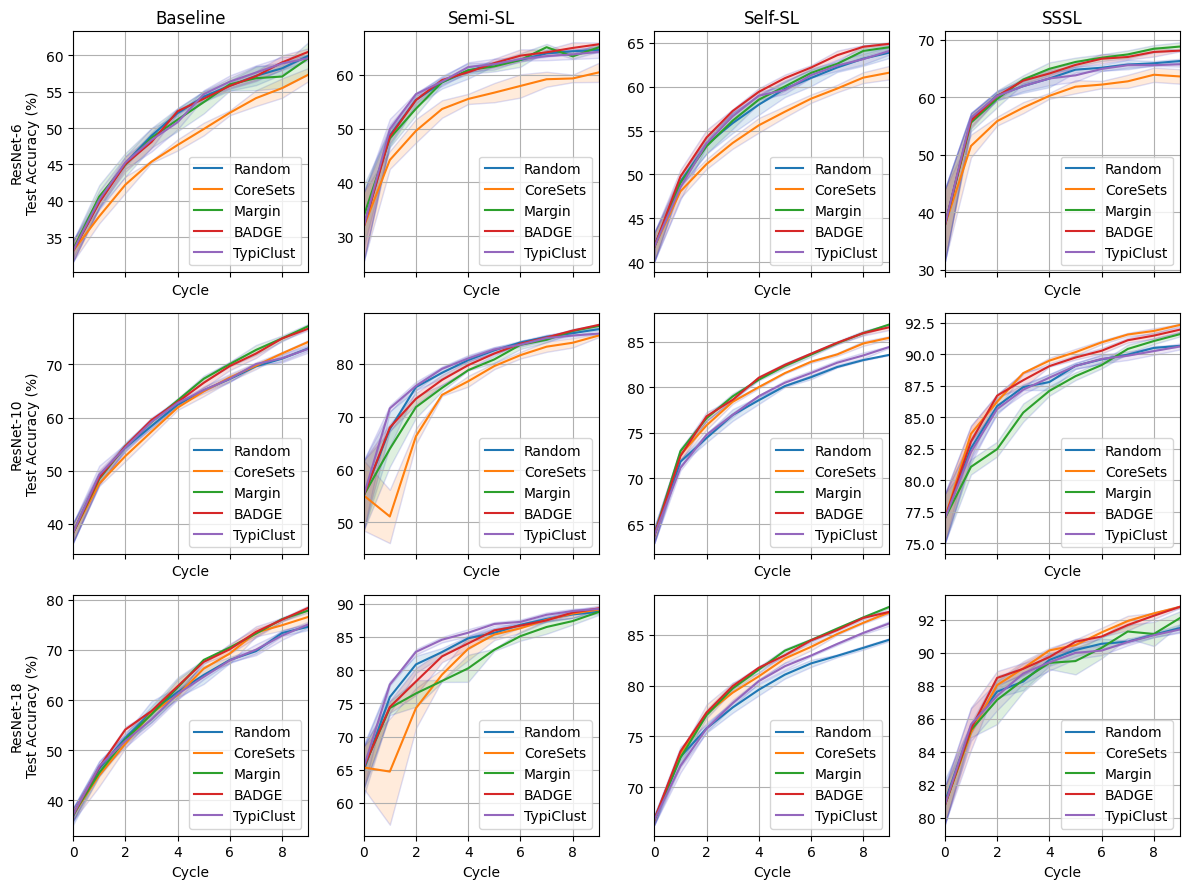

In [3]:
fig, axis = plt.subplots(nrows=3, ncols=4, figsize=(12, 9), tight_layout=True, sharex=True)#, sharey=True)

for i, mn in enumerate(model_names):
    for q in queries:
        for j, us in enumerate(use_SSL):
            for k, up in enumerate(use_PRE):
                l = j + k*2
                values = []
                for _, res in results[mn][q][us][up].items():
                    values.append([h['test_stats']['acc1'] for h in res['results']])

                if len(values) > 0:
                    mean = np.mean(values, axis=0)
                    std = np.std(values, axis=0)

                    axis[i][l].plot(mean, label=Q[q])
                    axis[i][l].fill_between(
                        x=[j for j in range(len(mean))], 
                        y1=mean+std, 
                        y2=mean-std,
                        alpha=0.15,
                        edgecolor='#1B2ACC', 
                        )
                    lgd = axis[i][l].legend(loc='lower right')
                    axis[i][l].set_xlim(0, len(mean)-1)
                    if i//2 == 1:
                        axis[i][l].set_xlabel('cycle')
                    if i == 0:
                        axis[i][l].set_title(['Baseline', 'Semi-SL', 'Self-SL', 'SSSL'][l])
                    if l == 0:
                        axis[i][l].set_ylabel(M[mn] + "\n" +"Test Accuracy (%)")
                    axis[i][l].set_xlabel('Cycle')
                    axis[i][l].grid(True)
plt.show()

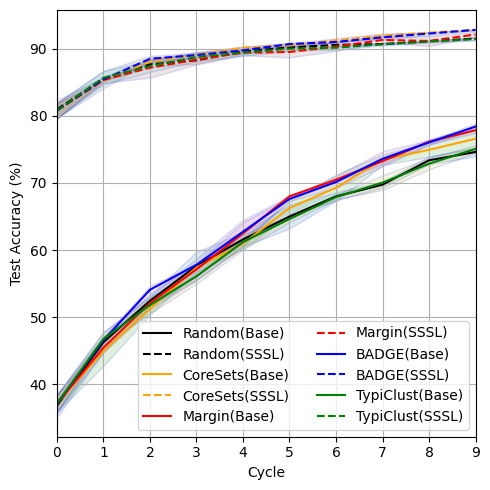

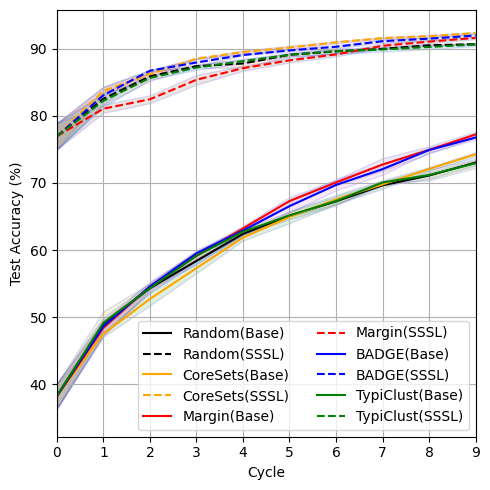

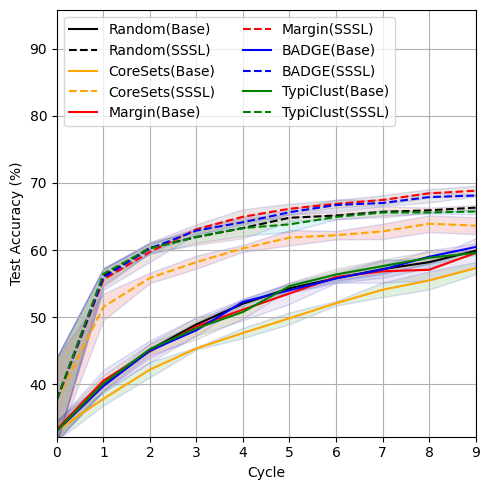

In [4]:
ylim = None

for mn in model_names[::-1]:
    plt.figure(figsize=(5,5), tight_layout=True)
    for q in queries:

        for use in ['False', 'True']:
            values = []
            for _, res in results[mn][q][use][use].items():
                values.append([h['test_stats']['acc1'] for h in res['results']])

            if len(values) == 0:
                print(mn, q)
            else:
                mean = np.mean(values, axis=0)
                std = np.std(values, axis=0)

                plt.plot(mean, c=Q_colors[q], linestyle='-' if use == 'False' else '--', label=Q[q]+('(Base)' if use == 'False' else '(SSSL)'))
                plt.fill_between(
                    x=[j for j in range(len(mean))], 
                    y1=mean+std, 
                    y2=mean-std,
                    alpha=0.15,
                    edgecolor='#1B2ACC', 
                    )
    lgd = plt.legend(loc='upper left' if mn == 'resnet6' else 'lower right', ncol=2)
    plt.xlim(0, len(mean)-1)
    plt.grid(True)
    plt.xlabel('Cycle')
    plt.ylabel("Test Accuracy (%)")
    if ylim:
        plt.ylim(ylim)
    else:
        ylim = plt.ylim()
    #plt.show()
    plt.savefig('/home/phahn/repositories/SDAL/images/dal_results_'+ mn +'.pdf', bbox_inches='tight')

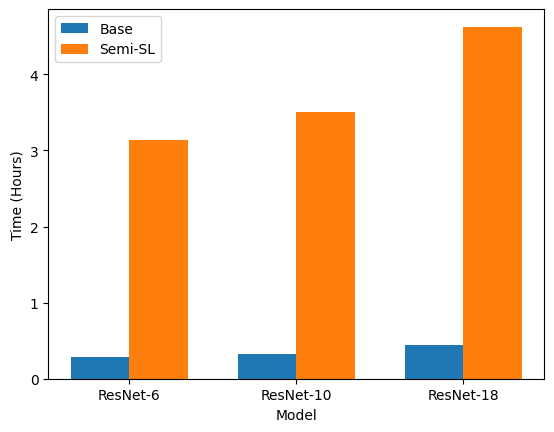

In [5]:
# Plot bar plot of runtimes for each model

ar = []
q = 'random'
for mn in model_names:
    a = []
    for us in use_SSL:
        values = []
        for _, res in results[mn][q][us]['False'].items():
            values.append([h['training_time'] for h in res['results']])

        a.append(np.mean(np.sum(values, axis=1))/3600)
    ar.append(a)

xx, yy = zip(*ar)
group_labels = ['ResNet-6', 'ResNet-10', 'ResNet-18']
x = np.arange(len(group_labels))
width = 0.35

fig = plt.figure()
plt.bar(x - width/2, xx, width, label='Base')
plt.bar(x + width/2, yy, width, label='Semi-SL')
plt.xlabel('Model')
plt.xticks(ticks=x, labels=group_labels)
plt.ylabel('Time (Hours)')
plt.legend()
plt.show()